<a href="https://colab.research.google.com/github/VictorTome/Advanced-Machine-Learning-Credit-Card-Churn-Prediction/blob/main/Spark_Big_DT_Analytics_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Churn.csv to Churn (1).csv
root
 |-- AccountLength: integer (nullable = true)
 |-- VMailMessage: integer (nullable = true)
 |-- DayMins: double (nullable = true)
 |-- EveMins: double (nullable = true)
 |-- NightMins: double (nullable = true)
 |-- IntlMins: double (nullable = true)
 |-- CustServCalls: integer (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- IntlPlan: integer (nullable = true)
 |-- VMailPlan: integer (nullable = true)
 |-- DayCalls: integer (nullable = true)
 |-- DayCharge: double (nullable = true)
 |-- EveCalls: integer (nullable = true)
 |-- EveCharge: double (nullable = true)
 |-- NightCalls: integer (nullable = true)
 |-- NightCharge: double (nullable = true)
 |-- IntlCalls: integer (nullable = true)
 |-- IntlCharge: double (nullable = true)
 |-- State: string (nullable = true)
 |-- AreaCode: integer (nullable = true)
 |-- Phone: string (nullable = true)

+-------+------------------+------------------+------------------+------------------+---------

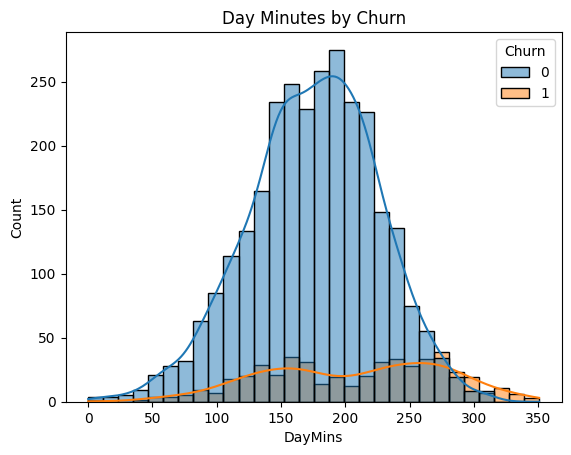

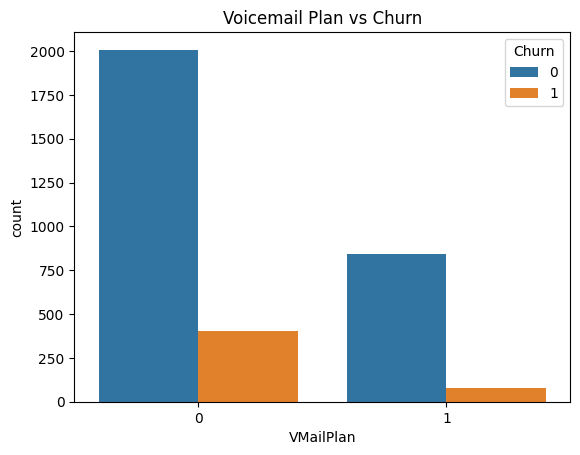

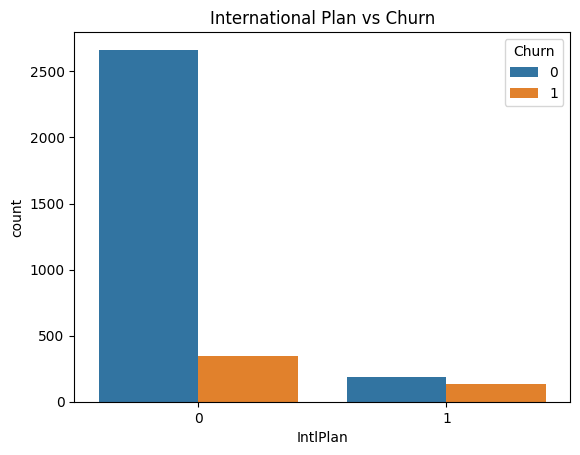

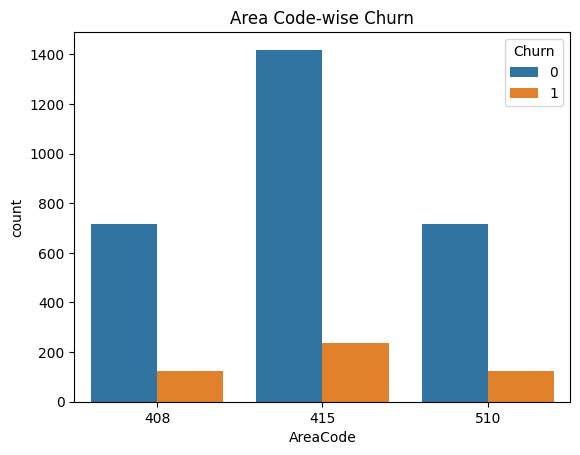

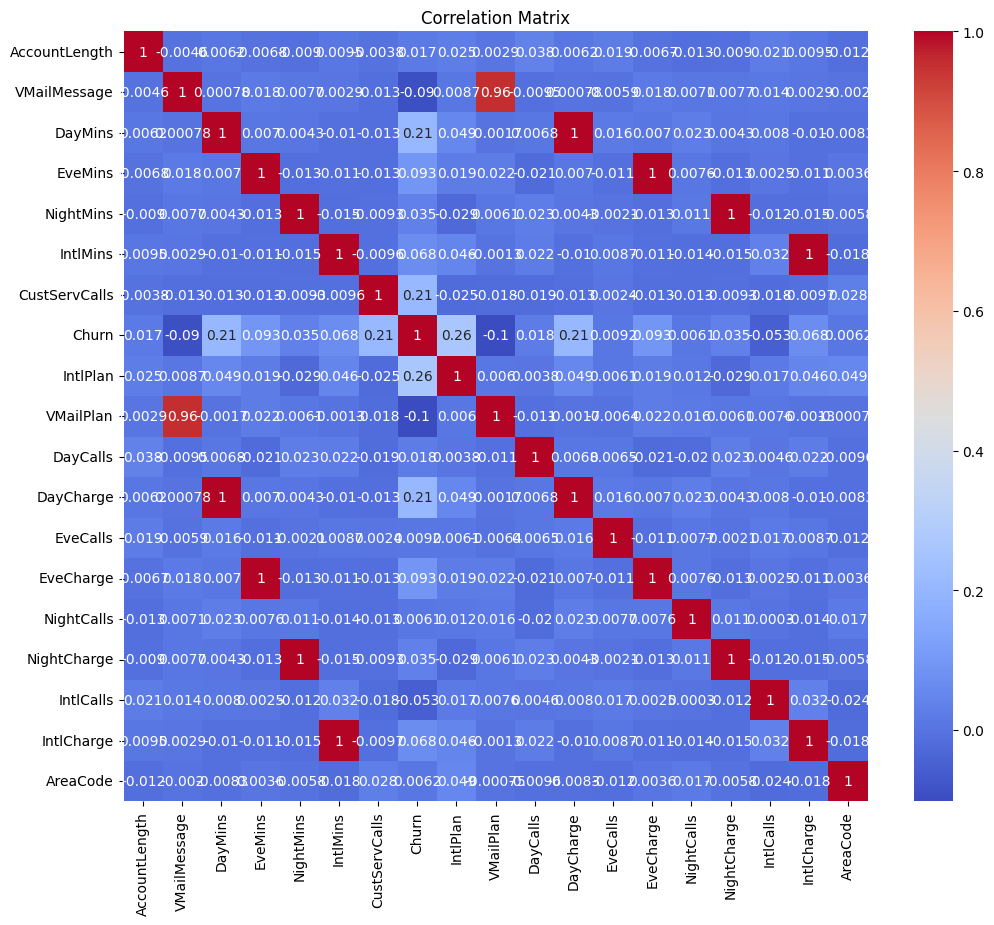

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize Spark Session
spark = SparkSession.builder.appName("ChurnPrediction").getOrCreate()

# Load data

from google.colab import files
uploaded = files.upload()

churn_data_path = "Churn.csv"

churn = spark.read.csv("Churn.csv", header=True, inferSchema=True)
churn.printSchema()

# 7.1 Describe the data
churn.describe().show()

# 7.2 Histogram for DayMins by Churn
pdf = churn.select("DayMins", "Churn").toPandas()
sns.histplot(data=pdf, x="DayMins", hue="Churn", bins=30, kde=True)
plt.title("Day Minutes by Churn")
plt.show()

# 7.3 Count plot for Voicemail plan vs Churn
pdf = churn.select("VMailPlan", "Churn").toPandas()
sns.countplot(data=pdf, x="VMailPlan", hue="Churn")
plt.title("Voicemail Plan vs Churn")
plt.show()

# 7.4 Count plot for Intl Plan vs Churn
pdf = churn.select("IntlPlan", "Churn").toPandas()
sns.countplot(data=pdf, x="IntlPlan", hue="Churn")
plt.title("International Plan vs Churn")
plt.show()

# 7.5 Area wise churn plot
area_churn = churn.groupBy("AreaCode", "Churn").count().toPandas()
sns.barplot(data=area_churn, x="AreaCode", y="count", hue="Churn")
plt.title("Area Code-wise Churn")
plt.show()

# 7.6 Correlation matrix (via pandas)
# Changed df.columns to churn.columns
corr_data = churn.select([col(c).cast("double") for c in churn.columns if c not in ['State', 'Phone']]).toPandas()
plt.figure(figsize=(12,10))
sns.heatmap(corr_data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [4]:
# 9.1 - Import necessary libraries
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 9.2 - Create vectors of all independent variables
# First, convert string columns (like 'IntlPlan' and 'VMailPlan') into numerical using StringIndexer
indexers = [
    StringIndexer(inputCol="IntlPlan", outputCol="IntlPlanIndex"),
    StringIndexer(inputCol="VMailPlan", outputCol="VMailPlanIndex")
]

# List of feature columns (excluding Churn and already indexed string columns)
feature_cols = [
    'AccountLength', 'VMailMessage', 'DayMins', 'DayCalls', 'DayCharge',
    'EveMins', 'EveCalls', 'EveCharge', 'NightMins', 'NightCalls', 'NightCharge',
    'IntlMins', 'IntlCalls', 'IntlCharge', 'CustServCalls',
    'IntlPlanIndex', 'VMailPlanIndex'
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# 9.3 - Apply Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="Churn", featuresCol="features")

# 9.4 - Create a pipeline to build the classifier
pipeline = Pipeline(stages=indexers + [assembler, dt])

# 9.5 - Use stratified sampling (approx) to get a sample of data
# Optional: You can skip this if using full data
# df_sample = df.sampleBy("Churn", fractions={0: 0.5, 1: 1.0}, seed=42)

# 9.6 - Split the data into train and test dataset
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

# 9.7 - Make predictions and validate the model
model = pipeline.fit(train_data)
predictions = model.transform(test_data)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="Churn", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Decision Tree Accuracy: {accuracy:.2f}")

# 9.8 - Calculate recall and precision
precision_eval = MulticlassClassificationEvaluator(
    labelCol="Churn", predictionCol="prediction", metricName="weightedPrecision")
recall_eval = MulticlassClassificationEvaluator(
    labelCol="Churn", predictionCol="prediction", metricName="weightedRecall")

precision = precision_eval.evaluate(predictions)
recall = recall_eval.evaluate(predictions)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# 9.9 - Test the model using test data again (already done above)
# Optional additional print:
print("\nModel Performance on Test Data:")
print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

# 9.10 - Repeat with RandomForest and Gradient Boost Classifiers

### Random Forest
rf = RandomForestClassifier(labelCol="Churn", featuresCol="features", numTrees=100)
pipeline_rf = Pipeline(stages=indexers + [assembler, rf])
model_rf = pipeline_rf.fit(train_data)
pred_rf = model_rf.transform(test_data)
acc_rf = evaluator.evaluate(pred_rf)
prec_rf = precision_eval.evaluate(pred_rf)
rec_rf = recall_eval.evaluate(pred_rf)
print(f"\nRandom Forest - Accuracy: {acc_rf:.2f}, Precision: {prec_rf:.2f}, Recall: {rec_rf:.2f}")

### Gradient Boosted Trees
gbt = GBTClassifier(labelCol="Churn", featuresCol="features", maxIter=50)
pipeline_gbt = Pipeline(stages=indexers + [assembler, gbt])
model_gbt = pipeline_gbt.fit(train_data)
pred_gbt = model_gbt.transform(test_data)
acc_gbt = evaluator.evaluate(pred_gbt)
prec_gbt = precision_eval.evaluate(pred_gbt)
rec_gbt = recall_eval.evaluate(pred_gbt)
print(f"\nGradient Boosted Trees - Accuracy: {acc_gbt:.2f}, Precision: {prec_gbt:.2f}, Recall: {rec_gbt:.2f}")


Decision Tree Accuracy: 0.94
Precision: 0.94
Recall: 0.94

Model Performance on Test Data:
Accuracy: 0.94, Precision: 0.94, Recall: 0.94

Random Forest - Accuracy: 0.94, Precision: 0.94, Recall: 0.94

Gradient Boosted Trees - Accuracy: 0.95, Precision: 0.95, Recall: 0.95
